In [110]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

In [111]:
# india borders
NORTH = 37.1
SOUTH = 8.07
WEST = 68.12
EAST = 97.42

STEP = 0.01

def get_idx(lat, lon):
    return (int((NORTH - lat) / STEP), int((lon - WEST) / STEP))

def get_lat_lon(idx):
    return (NORTH - idx[0] * STEP, WEST + idx[1] * STEP)

num_lat_steps = int((NORTH - SOUTH) / STEP)
num_lon_steps = int((EAST - WEST) / STEP)

In [112]:
def exponential_decay(distance_squared):
    return np.exp(-6 * distance_squared)

In [113]:
hospitals = pd.read_csv('hospital_dataset_cleaned.csv')
hospitals['Radius of Influence'] = hospitals['Effective Rating'] * 0.1

In [114]:
def get_influence_map(hospitals, lat_col, lon_col):
    influence_map = np.zeros((num_lat_steps, num_lon_steps))
    for i in range(len(hospitals)):
        lat, lon = hospitals.loc[i, lat_col], hospitals.loc[i, lon_col]
        idx, jdx = get_idx(lat, lon)
        r = hospitals.loc[i, 'Radius of Influence']
        r_steps = int(r / STEP)

        # Define the bounding box for influence radius
        start_i = max(0, idx - r_steps)
        end_i = min(num_lat_steps, idx + r_steps + 1)
        start_j = max(0, jdx - r_steps)
        end_j = min(num_lon_steps, jdx + r_steps + 1)

        # Generate grid of indices within the bounding box
        x_coords, y_coords = np.meshgrid(np.arange(start_i, end_i), np.arange(start_j, end_j), indexing='ij')
        distance_squared = ((x_coords - idx) ** 2 + (y_coords - jdx) ** 2) * STEP**2

        # Apply influence decay only to points within the radius
        mask = distance_squared <= r**2
        influence_map[x_coords[mask], y_coords[mask]] += exponential_decay(distance_squared[mask])

    return influence_map

influence_map = get_influence_map(hospitals, 'Latitude', 'Longitude')

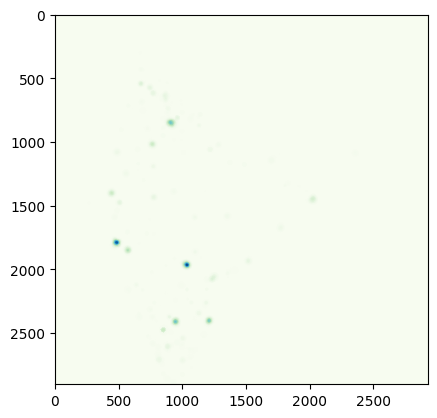

In [115]:
# plot influence map pixel by pixel
import matplotlib.pyplot as plt
plt.imshow(influence_map, cmap='GnBu', interpolation='nearest')
plt.savefig('influences1.png')

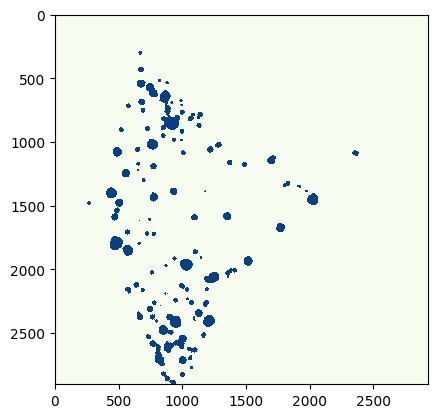

In [116]:
clustering_cutoff = np.percentile(influence_map[influence_map > 0], 50)
binary_map = (influence_map > clustering_cutoff).astype(int)
plt.imshow(binary_map, cmap='GnBu', interpolation='nearest')

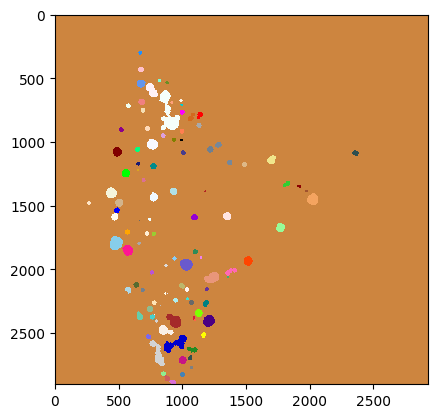

In [117]:
from scipy.ndimage import label
import random

clusters, num_clusters = label(binary_map)

import matplotlib.colors as mcolors

num_colors = num_clusters + 1
colors = list(mcolors.CSS4_COLORS.values())
random.shuffle(colors)
random_cmap = mcolors.ListedColormap(colors[:num_colors])

plt.imshow(clusters, cmap=random_cmap, interpolation='nearest')
plt.savefig('clusters.png')

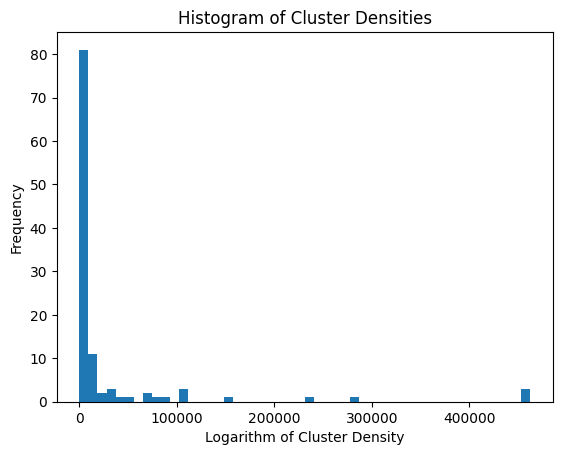

In [129]:
cluster_densities = [influence_map[clusters == cluster_id].sum() for cluster_id in range(1, num_clusters + 1)]
plt.hist(np.log(cluster_densities), bins=20)
plt.xlabel("Logarithm of Cluster Density")
plt.ylabel("Frequency")
plt.title("Histogram of Cluster Densities")
plt.show()

In [130]:
from scipy.spatial import ConvexHull, Delaunay

def precompute_cluster_properties(clusters):
    cluster_properties = {}
    
    unique_clusters = np.unique(clusters)
    
    for cluster_id in unique_clusters:
        if cluster_id == 0: 
            continue
            
        cluster_coords = np.array(np.where(clusters == cluster_id)).T
        
        if len(cluster_coords) < 3:
            continue
            
        centroid = cluster_coords.mean(axis=0)
        hull = ConvexHull(cluster_coords)
        hull_points = cluster_coords[hull.vertices]
        
        distances = np.linalg.norm(hull_points - centroid, axis=1)
        min_radius = distances.min()
        
        cluster_properties[cluster_id] = {
            "centroid": centroid,
            "hull": hull,
            "hull_points": hull_points,
            "min_radius": min_radius,
            "delaunay_region": Delaunay(hull_points)
        }
    
    return cluster_properties


def add_clustered_noise(lat, lon, cluster_properties):
    idx, jdx = get_idx(lat, lon)
    
    cluster_id = clusters[idx, jdx]
    if cluster_id not in cluster_properties:
        return lat, lon  
    
    properties = cluster_properties[cluster_id]
    centroid = properties["centroid"]
    min_radius = properties["min_radius"]
    delaunay_region = properties["delaunay_region"]
    
    for attempt in range(256):
        noise_direction = np.random.randn(2)  #random direction
        noise_direction /= np.linalg.norm(noise_direction)  
        noise_magnitude = np.random.uniform(0, min_radius)
        noise = noise_magnitude * noise_direction
        
        new_coords = np.array([idx, jdx]) + noise
        new_lat, new_lon = get_lat_lon(new_coords)
        
        if delaunay_region.find_simplex(new_coords) >= 0:
            return new_lat, new_lon  
    
    return lat, lon


In [131]:
cluster_properties = precompute_cluster_properties(clusters)

for i in range(len(hospitals)):
    lat, lon = hospitals.loc[i, 'Latitude'], hospitals.loc[i, 'Longitude']
    new_lat, new_lon = add_clustered_noise(lat, lon, cluster_properties)
    hospitals.loc[i, 'Latitude_anon'] = new_lat
    hospitals.loc[i, 'Longitude_anon'] = new_lon

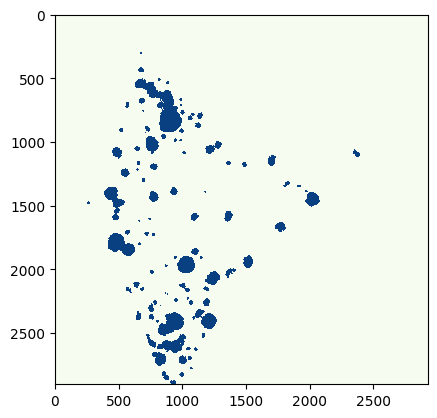

In [132]:
anon_influence_map = get_influence_map(hospitals, 'Latitude_anon', 'Longitude_anon')
anon_clustering_cutoff = np.percentile(anon_influence_map[anon_influence_map > 0], 50)
anon_binary_map = (anon_influence_map > anon_clustering_cutoff).astype(int)
plt.imshow(anon_binary_map, cmap='GnBu', interpolation='nearest')

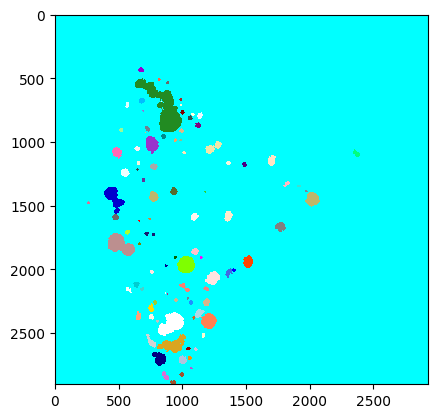

In [133]:
anon_clusters, anon_num_clusters = label(anon_binary_map)

anon_num_colors = anon_num_clusters + 1
colors = list(mcolors.CSS4_COLORS.values())
random.shuffle(colors)
random_cmap = mcolors.ListedColormap(colors[:num_colors])

plt.imshow(anon_clusters, cmap=random_cmap, interpolation='nearest')
plt.savefig('anon-clusters.png')

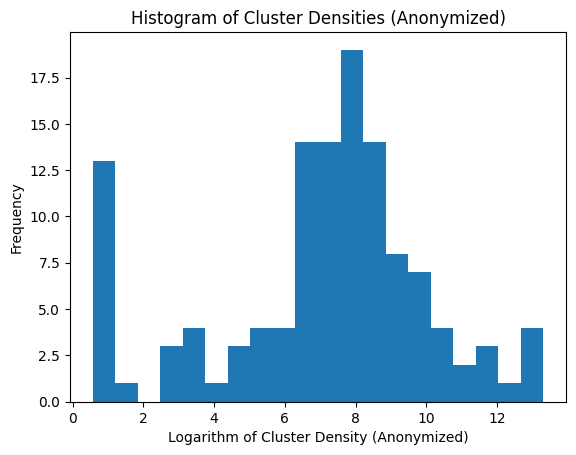

In [134]:
anon_cluster_densities = [anon_influence_map[anon_clusters == cluster_id].sum() for cluster_id in range(1, anon_num_clusters + 1)]
plt.hist(np.log(anon_cluster_densities), bins=20)
plt.xlabel("Logarithm of Cluster Density (Anonymized)")
plt.ylabel("Frequency")
plt.title("Histogram of Cluster Densities (Anonymized)")

plt.show()

In [ ]:
#TODO: compare both histograms
